For training, we decided to train on both CPC and CPM data in order to obtain more click samples. However, we only tested on CPC data from day 1.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json

## Loading in Data

In [2]:
# Load in data from HDF file, which is faster, filtered data
df_store = pd.HDFStore('data/combined_day1_processed.h5')
day1_filtered = df_store['df']

In [8]:
# UNFILTERED DATA FROM DAYS 1-4 (CPC AND CPM)
day1_negatives = pd.HDFStore('data/processed/day1_negatives_processed.h5')['df']
day1_positives = pd.HDFStore('data/processed/day1_positives_processed.h5')['df']
day2_negatives = pd.HDFStore('data/processed/day2_negatives_processed.h5')['df']
day2_positives = pd.HDFStore('data/processed/day2_positives_processed.h5')['df']
day3_negatives = pd.HDFStore('data/processed/day3_negatives_processed.h5')['df']
day3_positives = pd.HDFStore('data/processed/day3_positives_processed.h5')['df']
day4_negatives = pd.HDFStore('data/processed/day4_negatives_processed.h5')['df']
day4_positives = pd.HDFStore('data/processed/day4_positives_processed.h5')['df']

## Data Exploration

### New Data - Sample 2 Million

In [9]:
def get_sample(df, num):
    """Returns a random sample of num entries from df (without replacement)
    
    Args:
        df (dataframe): dataframe to sample from
        num (int): number of samples
        
    Returns:
        random sample
    """
    n = df.shape[0]
    idx = np.random.choice(n, size=num, replace=False)
    return df.iloc[idx]

NUM_SAMPLES = 125000 #num samples per dataframe
combined = pd.concat([get_sample(day1_negatives, NUM_SAMPLES), get_sample(day1_positives, NUM_SAMPLES),
                     get_sample(day2_negatives, NUM_SAMPLES), get_sample(day2_positives, NUM_SAMPLES),
                     get_sample(day3_negatives, NUM_SAMPLES), get_sample(day3_positives, NUM_SAMPLES),
                     get_sample(day4_negatives, NUM_SAMPLES), get_sample(day4_positives, NUM_SAMPLES)])

In [10]:
combined.shape

(1000000, 39)

In [11]:
combined.head()

,_host,ad_network_id,advertiser_id,c_cnt,c_flag_cnt,campaign_id,campaign_type,f_cnt,geo_city_name,geo_country_code3,...,ua_minor,ua_os_name,url,user_agent,uuid,vi_cnt,vi_flag_cnt,url_domain,red_domain,keywords
657450,an-prod-ralphie-frontline-soths.us-east-1,1403.0,3672.0,0.0,0.0,26733.0,private,0.0,Spanish Fort,USA,...,0.0,Windows 7,https://www.theburningplatform.com/page/3/,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,adda9c2b-af51-4120-840e-5a3a19e36f95,0.0,0.0,www.theburningplatform.com,www.theburningplatform.com,"[page, page]"
100138,an-prod-ralphie-frontline-fermi.eu-west-1,369.0,840.0,0.0,0.0,2547.0,rtb,0.0,Karachi,PAK,...,0.0,Windows 7,http://www.onlinetvchannels.net/sony-mix-live/...,Mozilla/5.0 (Windows NT 6.1; rv:56.0) Gecko/20...,c4619b73-187f-4b21-a421-48007d493cad,0.0,0.0,www.onlinetvchannels.net,,"[sony, mix, live]"
518345,an-prod-ralphie-frontline-emits.eu-west-1,734.0,2873.0,0.0,0.0,12816.0,third-party,1.0,Angarsk,RUS,...,0.0,Android,,Dalvik/2.1.0 (Linux; U; Android 7.0; SM-A520F ...,e27d414b-2a0b-4f7d-9b6a-077ac5378e38,0.0,0.0,,,[]
89038,an-prod-ralphie-frontline-bedim.us-east-1,2082.0,5238.0,0.0,0.0,26734.0,private,0.0,Arlington,USA,...,0.0,Android,https://thoughtcatalog.com/lorenzo-jensen-iii/...,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...,c23f1a75-a075-4aca-880f-474467fc00f8,0.0,0.0,thoughtcatalog.com,,"[lorenzo, jensen, iii, how, big, the, perfect,..."
784331,an-prod-ralphie-frontline-demit.us-east-1,1349.0,3587.0,0.0,0.0,20523.0,private,0.0,Clifton,USA,...,0.0,Android,http://www.chinalucky8.com/feeds/index.aspx#.W...,Mozilla/5.0 (Linux; Android 5.1; LUX Build/LMY...,20534aec-d141-4733-80e7-dfbb564925c7,1.0,0.0,www.chinalucky8.com,www.chinalucky8.com,"[feeds, index, aspx, links, index, aspx]"


In [11]:
# Find average ctr rate of each advertiser
def score_advertisers(table):
    """Find the average ctr rate
    
    Args:
        table (dataframe): dataframe to find the average ctr rates
        
    Returns:
        the ctr rate column
    """
    click_counts = table[["advertiser_id", "c_cnt"]]
    grouped = click_counts.groupby("advertiser_id")
    score_means = lambda x: np.mean(x)
    agg_scored = grouped.agg({'c_cnt': score_means})
    return agg_scored

# Merge with original dataframe
def add_ctr_rate(df):
    """Join the ctr rate column with the dataframe by the advertiser ID
    
    Args:
        df (dataframe): dataframe to merge the ctr rate column with
        
    Returns:
        the merged dataframe
    
    """
    click_rates = score_advertisers(combined).reset_index()
    # Add ctr rate column to the table
    click_rates.rename(columns={"c_cnt": "ctr_rate"}, inplace=True)
    return pd.merge(df, click_rates, on="advertiser_id")

In [ ]:
combined = add_ctr_rate(combined)
day1_filtered = add_ctr_rate(day1_filtered)

### OS Analysis

In [106]:
top_10_os = combined["ua_os_name"].value_counts()[:10].index

In [108]:
top_10_os_table = combined[combined["ua_os_name"].isin(top_10_os)]

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


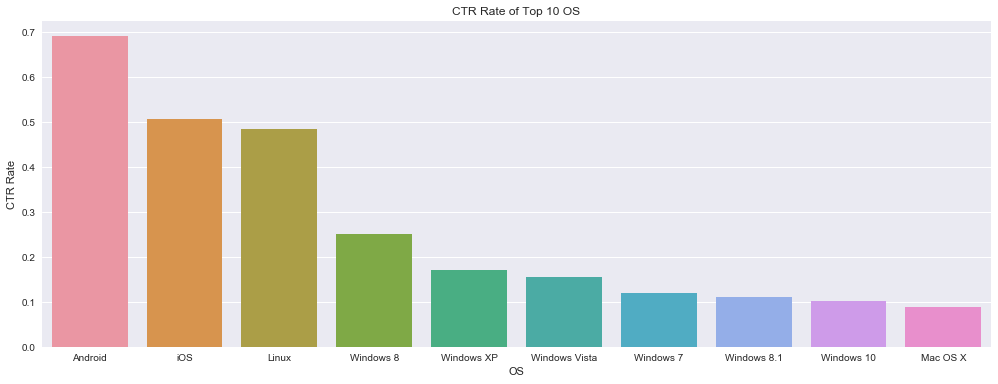

In [109]:
os_ctr_rate = (top_10_os_table[["ua_os_name", "c_cnt"]].groupby("ua_os_name").sum() / 
                   top_10_os_table[["ua_os_name", "c_cnt"]].groupby("ua_os_name").count())
os_ctr_rate.sort_values(by="c_cnt", inplace=True, ascending=False)

fig, ax = plt.subplots()
fig.set_size_inches(17, 6)
sns.barplot(x=os_ctr_rate.index.values, y=os_ctr_rate.c_cnt.values)
ax.set(xlabel='OS', ylabel='CTR Rate', title='CTR Rate of Top 10 OS')
plt.show()

# Feature Engineering  

In [43]:
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
# Shuffle Data
# combined = shuffle(combined)

Here, we are reading in processed data files that have been saved as pickle files. Day1_subset is the test set (CPC only), and combined is the training set (CPC and CPM)

In [ ]:
# combined.to_pickle("data/combined_days_processed")
# day1_filtered.to_pickle("data/day1_filtered")

In [4]:
combined = pd.read_pickle("./data/combined_days_processed")
day1_filtered = pd.read_pickle("./data/day1_filtered")

Encode keywords using a bag of words approach:

In [5]:
combined['keywords_split'] = combined['keywords'].apply(lambda lst: ' '.join(lst))
day1_filtered['keywords_split'] = day1_filtered['keywords'].apply(lambda lst: ' '.join(lst))

In [6]:
count_vec = CountVectorizer(min_df=1000) #keep words that appear in at least 1000 documents
count_vec.fit(combined['keywords_split'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1000,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [7]:
#Actual encoding 
combined_keywords_transform = count_vec.transform(combined['keywords_split']).toarray()

In [8]:
NUM_WORDS = combined_keywords_transform.shape[1]
NUM_WORDS

319

In [9]:
#Add the encoded keywords to combined dataframe
combined = pd.concat([combined, pd.DataFrame(combined_keywords_transform)], axis=1)

In [10]:
#Create subset of test set
idx = np.random.choice(day1_filtered.shape[0], size=500000, replace=False)
day1_subset = day1_filtered.iloc[idx]
click_spread = day1_subset.c_cnt.value_counts()
print("Non-click to click ratio of sample:", int(click_spread[0] / click_spread[1]))

None-click to click ratio of sample: 1491


In [11]:
#Encoded the keywords in the test set 
day1_keywords_transform = count_vec.transform(day1_subset['keywords_split']).toarray()

In [12]:
#Add the encoded keywords to day1_subset dataframe
day1_subset = pd.concat([day1_subset.reset_index(drop=True), pd.DataFrame(day1_keywords_transform)], axis=1)

Let's create our features:

In [3]:
#Features to one hot encode
FEATURES_TO_USE = ["advertiser_id", "ad_network_id", "geo_country_code3", "ua_os_name", 
                   "site_id", "ua_device", "campaign_id", "url_domain","geo_region_name", 
                   "red_domain", "pub_network_id", "geo_timezone", "ua_device_type", 
                   "ua_major", "ua_minor", "uuid"]

In [4]:
def transform_hour(x):
    """Assigns hour to a bin"""
    if x >= 5 and x < 8: return 1 #early morning 
    elif x >= 8 and x < 11: return 2 #morning 
    elif x >= 11 and x < 14: return 3 #midday
    elif x >= 14 and x < 19: return 4 #afternoon
    elif x >= 19 and x < 22: return 5 #evening
    else: return 6 #night
    
def create_numerical_features(sample):
    """Returns a dataframe with the necessary numberical features from dataframe sample
    
    Args:
        sample (dataframe): the dataframe from which we create the numerical features 
    
    Returns:
        the dataframe with the numerical features
    """
    df = pd.DataFrame()
    df["r_cnt"] = sample["r_cnt"].tolist()
    df["campaign_type"] = sample["campaign_type"].apply(lambda x: 1 if x == "private" else 0).tolist()
    df["ctr_rate"] = sample["ctr_rate"].tolist()
    df["num_ads_requested"] = sample["r_num_ads_requested"].tolist()
    df["hour"] = sample["i_timestamp"].astype(int).tolist()
    return df

# FFM (inspired by https://www.csie.ntu.edu.tw/~cjlin/papers/ffm.pdf)

In [5]:
import xlearn as xl
xl.hello() #xl only prints in terminal

In [6]:
KEYWORDS_INDEX = 41 #start index of keywords columns

In [7]:
encoders = {} #cache the one hot encoders

In [8]:
# Tracks number of columns per categorical feature, i.e. device_type has 4 columns (helps for conversion to FFM format)
feature_count = [] 

### Helper functions

In [9]:
# Create encoders and one hot encode features
def encode_feature(feature, sample, df, k=80):
    """Does limited one hot encoding (k most frequent) on the given feature from the sample dataframe. 
    If the one hot encoder for that specific feature doesn't exist, fit it to df first.
    
    Args:
        feature (str): the feature to one hot encode
        sample (dataframe): the dataframe that we encode the feature for
        df (dataframe): the dataframe that we fit the encoder to if it hasn't been created yet
        k (int): specifies top-k most frequent values to fit on
    
    Returns:
        the transformed feeature of the sample dataframe (2D array)
        
    """
    if feature not in encoders:
        encoder = preprocessing.LabelBinarizer()
        value_counts = df[feature].value_counts()
        encoder.fit(value_counts.iloc[:k].index.tolist()) #fit to k most frequent
        encoders[feature] = encoder #save that encoder for future use
    else:
        encoder = encoders[feature]
    return encoder.transform(sample[feature])

def create_numerical_features_ffm(sample):
    """Creates a dataframe with the necessary numberical features for the FFM model
    
    Args:
        sample (dataframe): the dataframe from which we create the numerical features 
    
    Returns:
        the dataframe with the numerical features
    """
    df = create_numerical_features(sample)
    #add the c_cnt column - the X and y values need to be part of the same matrix for FFM
    df = pd.concat([pd.DataFrame(sample["c_cnt"].tolist()), df], axis=1).reset_index(drop=True) 
    return df

def create_features_ffm(sample):
    """"Creates dataframe with the necessary features for the FFM model
    
    Args:
        sample (dataframe): the dataframe from which we create the features 
        
    Returns:
        the dataframe with the features
    """
    df = create_numerical_features_ffm(sample)
    features = [] #store all features 
    features.append(df)
    for feature in FEATURES_TO_USE:
        encoded = encode_feature(feature, sample, df=combined) #one hot encode the feature
        if len(feature_count) < len(FEATURES_TO_USE): feature_count.append(encoded.shape[1])
        features.append(pd.DataFrame(encoded))
        print(feature)
    features.append(sample.iloc[:, KEYWORDS_INDEX:]) #add the keywords columns
    return pd.concat(features, axis=1) #combine all transformed features

### FFM Data Processing

In [22]:
# Create training matrix
train_ffm_transformed = create_features_ffm(combined)

advertiser_id
ad_network_id
geo_country_code3
ua_os_name
site_id
ua_device
campaign_id
url_domain
geo_region_name
red_domain
pub_network_id
geo_timezone
ua_device_type
ua_major
ua_minor
uuid


In [23]:
# Create test matrix
test_ffm_transformed = create_features_ffm(day1_subset)

advertiser_id
ad_network_id
geo_country_code3
ua_os_name
site_id
ua_device
campaign_id
url_domain
geo_region_name
red_domain
pub_network_id
geo_timezone
ua_device_type
ua_major
ua_minor
uuid


In [24]:
train_ffm_transformed.shape

(1000000, 1405)

In [25]:
test_ffm_transformed.shape

(500000, 1405)

In [27]:
# Generate list of numeric feature names
numerics = train_ffm_transformed.columns[1:6].tolist()
numerics

['r_cnt', 'campaign_type', 'ctr_rate', 'num_ads_requested', 'hour']

In [28]:
# Rename columns to make it easier to transform to FFM format
train_ffm_transformed.columns = ["c_cnt"] + numerics + list(range(6, ncolumns))
test_ffm_transformed.columns = ["c_cnt"] + numerics + list(range(6, ncolumns))

In [29]:
train_ffm_transformed.head()

,c_cnt,r_cnt,campaign_type,ctr_rate,num_ads_requested,hour,6,7,8,9,...,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404
0,0.0,0.0,1,0.047654,10.0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,1,0.047654,10.0,12,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,1,0.047654,10.0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,1,0.047654,10.0,12,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,1.0,1,0.047654,4.0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
test_ffm_transformed.head()

,c_cnt,r_cnt,campaign_type,ctr_rate,num_ads_requested,hour,6,7,8,9,...,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404
0,0.0,1,1,0.000151,4,18,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0.0,1,1,0.000151,4,19,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,1,0,0.008364,1,21,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,1,1,0.000151,10,20,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,1,1,0.000155,10,20,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We will use Dask to convert the data to text files to feed into the FFM model (http://dask.pydata.org/en/latest/). It allows us to parallelize the conversion process (otherwise, it's insanely slow).

In [ ]:
ncolumns = train_ffm_transformed.columns.shape[0]
feature_count += [1 for _ in range(NUM_WORDS)] #add 1 for each keyword
len(feature_count) # number of categorical features

In [31]:
def convert_to_ffm_parallel(row):
    """Converts row to ffm format. 
    For an example format, visit the data format section at https://github.com/guestwalk/libffm
    """
    ncols = row.shape[0]
    datastring = ""
    datastring += str(int(row['c_cnt']))
    field_position = 0 #tracks which position we're at for the current categorical feature (ie third column of ua_device_type)
    feature_count_index = 0 #tracks which categorical feature we're currently on (index in feature_count array)
    for i in range(1, ncols):
        if field_position == feature_count[feature_count_index]:
            feature_count_index += 1
            field_position = 0
        # For numerical fields, we are creating a dummy field here
        if (i - 1) < len(numerics):
            #we are dealing with a numeric feature
            feat = numerics[i - 1]
            datastring = datastring + " "+str(i - 1)+":"+ str(i - 1)+":"+ str(row[feat])
        else:
            #categorical feature
            if row[i] == 1:
                datastring = datastring + " "+str(feature_count_index + 5)+":"+ str(i - 1)+":1"
            field_position += 1
    return datastring        
    
def apply_func(df):
    """Applies function to df"""
    return df.apply(lambda row: convert_to_ffm_parallel(row), axis=1)
  

In [32]:
import dask.dataframe as dd
from dask.multiprocessing import get
import time

ncores = 4 
dask_train_ffm = dd.from_pandas(train_ffm_transformed[:600000], npartitions=ncores)

Actual conversions; we will time how long it takes as well

In [33]:
t0 = time.time()
converted_train = dask_train_ffm.map_partitions(apply_func).compute(get=get) #convert training data
t1 = time.time()
print("Time:", t1-t0)

Time: 3351.321110010147


In [35]:
dask_test_ffm = dd.from_pandas(test_ffm_transformed, npartitions=ncores)

In [36]:
t0 = time.time()
converted_test = dask_test_ffm.map_partitions(apply_func).compute(get=get) #convert test data
t1 = time.time()
print("Time:", t1-t0)

Time: 2759.911721229553


In [37]:
# Convert to text files
with open("ffm/train_dask_ffm.txt", "w") as text_file:
    text_file.write(converted_train.str.cat(sep='\n'))
    
with open("ffm/test_dask_ffm.txt", "w") as text_file:
    text_file.write(converted_test.str.cat(sep='\n'))

### Hyperparameter Tuning for FFM

Split the training data into training and validation for hyperparameter tuning:

In [10]:
train = pd.read_csv('ffm/train_dask_ffm.txt', header = None)
train = shuffle(train)

In [11]:
train_size = int(0.9 * train.shape[0])
train_ffm, val_ffm = train[:train_size], train[train_size:]
np.savetxt('ffm/train_dask_ffm_sliced.txt', train_ffm.values, fmt='%s')
np.savetxt('ffm/val_dask_ffm_sliced.txt', val_ffm.values, fmt='%s')

In [12]:
y_val_true = pd.to_numeric(val_ffm[0].str[0]).tolist() #get the c_cnt column

In [28]:
epochs = 10

In [77]:
ffm_model = xl.create_ffm()  
ffm_model.setTrain("ffm/train_dask_ffm_sliced.txt")   # Training data
ffm_model.setValidate("ffm/val_dask_ffm_sliced.txt")  # Validation data
ffm_model.setTest("ffm/val_dask_ffm_sliced.txt") # Test data
# ffm_model.setSigmoid() #makes outputs between 0 and 1
ffm_model.disableEarlyStop();
ffm_model.setSign() #makes outputs either 0 or 1

# param:
#  0. task - binary classification
#  1. lr - learning rate
#  2. lambda - regularization parameter 
#  3. metric - Metric for monitoring validation set performance 
#  4. epoch - Maximum number of Epochs
#  5. k - Length of latent vector for each feature

best_f1 = float('-inf')
for lr in np.linspace(0.05, 1, num=7):
    for lmbda in np.linspace(0.0001, 0.001, num=7):
        param = {'task':'binary', 'lr':lr, 'lambda':lmbda,'metric':'auc','epoch':epochs, 'k':8}
        # Train model
        ffm_model.fit(param, "ffm/dask_model.out")
        ffm_model.predict("ffm/dask_model.out", "ffm/dask_output.txt") #predicts on validation data
        y_pred_ffm = pd.read_csv('ffm/dask_output.txt', header = None)
        current_f1 = f1_score(y_val_true, y_pred_ffm)
        if current_f1 > best_f1:
            best_f1, best_lr, best_lmbda = current_f1, lr, lmbda

In [79]:
print("Best F1: %f, Best learning rate: %f, Best lambda: %f" % (best_f1, best_lr, best_lmbda))

Best F1: 0.901571, Best learning rate: 1.000000, Best lambda: 0.000100


Disclaimer: The validation data was generated from the unfiltered data (CPC and CPM), which may be why the F1 score was so much higher. We believe there may inherently be some different patterns between the CPC and CPM data which caused the performance on the test set (only CPC data) to be lower.

### Training and testing FFM model

We are testing on CPC data only; training data consists of both CPC and CPM data so that we can have more positive samples

In [20]:
test = pd.read_csv('ffm/test_dask_ffm.txt', header = None)

In [21]:
y_test_true = pd.to_numeric(test[0].str[0]).tolist() #get the c_cnt column

Single FFM:

In [29]:
# Training task
ffm_model = xl.create_ffm()  
ffm_model.setTrain("ffm/train_dask_ffm.txt")   
ffm_model.setValidate("ffm/test_dask_ffm.txt") 
ffm_model.setTest("ffm/test_dask_ffm.txt") 
# ffm_model.setSigmoid()
ffm_model.disableEarlyStop();
ffm_model.setSign() 

param = {'task':'binary', 'lr':best_lr, 'lambda':best_lmbda,'metric':'auc','epoch':epochs, 'k':8}
# Train model
ffm_model.fit(param, "ffm/dask_model.out")
ffm_model.predict("ffm/dask_model.out", "ffm/dask_output.txt") #predicts on validation data
y_pred_ffm = pd.read_csv('ffm/dask_output.txt', header = None)

confusion_ffm = confusion_matrix(y_test_true, y_pred_ffm) #00 - TN, 10 - FN, 01 - FP, 11 - TP
print("FFM Confusion Matrix:\n", confusion_ffm)

precision_ffm = confusion_ffm[1][1] / (confusion_ffm[1][1] + confusion_ffm[0][1])
recall_ffm = confusion_ffm[1][1] / (confusion_ffm[1][1] + confusion_ffm[1][0])
print("FFM Precision:", precision_ffm)
print("FFM Recall:", recall_ffm)

print("FFM F1 Score:", f1_score(y_test_true, y_pred_ffm)) #better F1 score!

FFM Confusion Matrix:
 [[487774  11891]
 [   264     71]]
FFM Precision: 0.00593546229727
FFM Recall: 0.211940298507
FFM F1 Score: 0.0115475319184


Train an ensemble of FFMs:

In [55]:
#Create an ensemble of ffms
NUM_ENSEMBLES = 10
ffm_models = []
for i in range(NUM_ENSEMBLES):
    sample = train.sample(n=train.shape[0], replace=True) #train on a subset of the data (sample with replacement)
    file_name = 'ffm/train_dask_ffm_' + str(i) + '.txt'
    np.savetxt(file_name, sample.values, fmt='%s')
    ffm = xl.create_ffm()
    ffm.setTrain(file_name)   # Training data
    ffm.setValidate("ffm/test_dask_ffm.txt")  # Validation data
    ffm.setTest("ffm/test_dask_ffm.txt") # Test data
    ffm.disableEarlyStop();
#     ffm.setSign() #makes outputs either 0 or 1
    ffm.setSigmoid()
    ffm_models.append(ffm)

In [56]:
#Train the ensembles
param = {'task':'binary', 'lr':best_lr, 'lambda':best_lmbda,'metric':'auc','epoch':epochs, 'k':8}
predictions = np.zeros((NUM_ENSEMBLES, test.shape[0]))
for i in range(NUM_ENSEMBLES):
    output_name = 'ffm/dask_model_'  + str(i) + '.out'
    prediction_name = "ffm/dask_output_" + str(i) + ".txt"
    model = ffm_models[i]
    model.fit(param, output_name)
    model.predict(output_name, prediction_name)
    y_pred_ffm = pd.read_csv(prediction_name, header = None)
    predictions[i, :] = y_pred_ffm.values.flatten()

#Average the predictions
# avg_predictions = np.round(np.mean(predictions, axis=0))

In [57]:
avg_predictions = np.mean(predictions, axis=0)
avg_predictions

array([ 0.00656104,  0.00617417,  0.00560469, ...,  0.7065214 ,
        0.00827208,  0.01272311])

In [58]:
log_loss(y_test_true, avg_predictions)

0.069803485993286979

In [ ]:
rounded_predictions = np.round(avg_predictions)

In [ ]:
confusion_ffm = confusion_matrix(y_test_true, rounded_predictions) #00 - TN, 10 - FN, 01 - FP, 11 - TP
print("Ensemble FFM Confusion Matrix:\n", confusion_ffm)

precision_ffm = confusion_ffm[1][1] / (confusion_ffm[1][1] + confusion_ffm[0][1])
recall_ffm = confusion_ffm[1][1] / (confusion_ffm[1][1] + confusion_ffm[1][0])
print("Ensemble FFM Precision:", precision_ffm)
print("Ensemble FFM Recall:", recall_ffm)
print("F1 score of FFM ensembles: %f" % f1_score(y_test_true, rounded_predictions))